In [1]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

--2021-06-15 14:01:58--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: ‘full_grams_cbow_300_twitter.zip’

full_grams_cbow_300 100%[===================>]   3.10G   107MB/s    in 75s     

2021-06-15 14:03:13 (42.2 MB/s) - ‘full_grams_cbow_300_twitter.zip’ saved [3325529808/3325529808]

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


In [3]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam,SGD
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import gensim
import re
from nltk import ngrams

In [5]:
def process_csv(df):
    
    df=df.drop(columns=['Case','lemma', 'Gender','Number','State','Gloss','Proclitic 1','Proclitic 2','Proclitic 0','Aspect','Mood','Person','Voice','Enclitic 0'])
    df=df.drop_duplicates()
    df["POS"] = df["POS"].apply(lambda x: x.replace("Proper Noun", "ProperNoun"))
    df["RANK"] = df.groupby('sentence_id').cumcount()
    df1 = pd.DataFrame(columns = ['x','y','z'])
    for i in df['sentence_id'].unique():
        df1 = df1.append({'x':df[df['sentence_id'] == i]['word'].tolist() , 'y':df[df['sentence_id'] == i]['POS'].tolist()},ignore_index=True)
    return df1

In [7]:
import pandas as pd

df1=pd.read_csv('/content/POS-first-dataset.csv')
df2=pd.read_csv('/content/description_mor.csv')
csvs = [df1,df2]
final_df = pd.DataFrame()
df1 = process_csv(df1)
df2=process_csv(df2)
final_df = pd.concat([df1,df2])
final_df = final_df.sample(frac = 1)
final_df.reset_index(drop=True, inplace=True)
final_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,x,y,z
0,"[ذكرت, وزارة, الصحة, المغربية, ,, أن, العدد, ا...","[Verb, Noun, Noun, Adjective, Punctuation, Sub...",NaN
1,"[الأوقاف, :, لا, مخالفات, في, تطبيق, قرار, غلق...","[Noun, Punctuation, Pseudo Verb, Noun, Preposi...",NaN
2,"[الكرملين, :, بوتين, أكد, لبايدن, أن, تطبيع, ا...","[ProperNoun, Punctuation, ProperNoun, Verb, Pr...",NaN
3,"[الصحة, الإماراتية, :, تسجيل, 525, إصابة, جديد...","[Noun, Adjective, Punctuation, Noun, Digit, No...",NaN
4,"[أعلن, الرئيس, التونسي, قيس, سعيد, ,, أنه, مست...","[Verb, Noun, Adjective, ProperNoun, ProperNoun...",NaN


In [8]:
x_tokenizer = Tokenizer(oov_token = "<OOV>")                    
x_tokenizer.fit_on_texts(final_df['x'].tolist())  
VOCABULARY_SIZE = len(x_tokenizer.word_index) + 1                  
x = x_tokenizer.texts_to_sequences(final_df['x'].tolist())

z= final_df['z'].tolist()

In [9]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(final_df['y'].tolist())
y = y_tokenizer.texts_to_sequences(final_df['y'].tolist())

In [11]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = max([len(final_df['x'][i]) for i in range(len(final_df))])
print(MAX_SEQUENCE_LENGTH)

39


In [12]:
x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = to_categorical(y)

In [13]:
x_train = np.array(x[:int(len(x)*0.7)])
x_val = np.array(x[int(len(x)*0.7):int(len(x)*0.9)])
x_test = np.array(x[int(len(x)*0.9):])
y_train = np.array(y[:int(len(y)*0.7)])
y_val = np.array(y[int(len(y)*0.7):int(len(y)*0.9)])
y_test = np.array(y[int(len(y)*0.9):])

In [14]:
print(x_train[0],y_train[0])

[  413    26    27   748     3    13   730  1550 11563   362  3893  4326
   136     4 17341    35    30    10    43   806   230   420    24 17342
   603  2646  8948   293 11564   892    16    66    91    93   113     0
     0     0     0] [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [15]:
arvec_embedding = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')

In [16]:
embeddings_index = {}
for word,vector in zip(arvec_embedding.wv.vocab,arvec_embedding.wv.vectors):
    coefs = np.asarray(vector, dtype='float32')
    embeddings_index[word] = coefs

In [18]:
embeddings_matrix = np.zeros((VOCABULARY_SIZE, embedding_dim))
for word, i in x_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [24]:

NUM_CLASSES = y_train.shape[2]
print(NUM_CLASSES)

33


In [65]:
model = Sequential()
model.add(InputLayer((MAX_SEQUENCE_LENGTH)))
model.add(Embedding(input_dim = VOCABULARY_SIZE,
                             output_dim    = embedding_dim,
                             input_length  = MAX_SEQUENCE_LENGTH,
                             #weights       = [embeddings_matrix],
                             trainable     = True
))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))


model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 39, 300)           9859500   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 39, 512)           1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 39, 512)           1574912   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 39, 33)            16929     
Total params: 14,166,989
Trainable params: 14,166,989
Non-trainable params: 0
_________________________________________________________________


In [67]:

checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [68]:
result = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = 40, batch_size= 128, shuffle = True,callbacks=[checkpoint])

Epoch 1/40
79/79 [==============================] - 24s 176ms/step - loss: 1.3700 - accuracy: 0.6529 - val_loss: 0.8208 - val_accuracy: 0.7608

Epoch 00001: val_accuracy improved from -inf to 0.76080, saving model to model_checkpoint.h5
Epoch 2/40
79/79 [==============================] - 11s 145ms/step - loss: 0.7966 - accuracy: 0.7636 - val_loss: 0.6261 - val_accuracy: 0.8145

Epoch 00002: val_accuracy improved from 0.76080 to 0.81449, saving model to model_checkpoint.h5
Epoch 3/40
79/79 [==============================] - 11s 144ms/step - loss: 0.4591 - accuracy: 0.8616 - val_loss: 0.2412 - val_accuracy: 0.9376

Epoch 00003: val_accuracy improved from 0.81449 to 0.93761, saving model to model_checkpoint.h5
Epoch 4/40
79/79 [==============================] - 11s 145ms/step - loss: 0.1684 - accuracy: 0.9557 - val_loss: 0.1999 - val_accuracy: 0.9518

Epoch 00004: val_accuracy improved from 0.93761 to 0.95176, saving model to model_checkpoint.h5
Epoch 5/40
79/79 [=========================

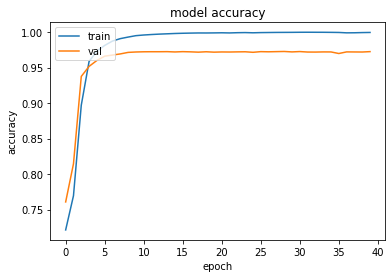

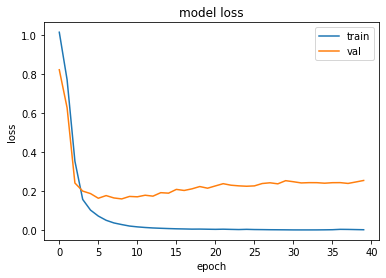

In [69]:
#Plot Accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

#Plot Loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [70]:
model.load_weights('model_checkpoint.h5')

In [71]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

45/45 [==============================] - 0s 10ms/step - loss: 0.2352 - accuracy: 0.9726
Loss: 0.23515602946281433,
Accuracy: 0.9725825786590576


In [72]:
def pos_tagger(sent):
    words = sent.split()
    words = [x_tokenizer.texts_to_sequences(words)]
    words = pad_sequences(words, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    words = np.squeeze(words,axis=-1)
    tags = np.squeeze(model.predict(words).argmax(-1))
    tags = [y_tokenizer.index_word[tag] for tag in tags if tag != 0]
    return tags

In [73]:
sentence = "جون يحب البيت الأزرق في نهاية الشارع"
output = pos_tagger(sentence)
pred_tags = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
for w,t in pred_tags:
    print(w,t)

جون propernoun
يحب noun
البيت noun
الأزرق noun
في preposition
نهاية noun
الشارع noun


In [74]:
Y_test_plot = y_test.argmax(-1)
pred = np.squeeze(model.predict(x_test).argmax(-1))
print(Y_test_plot.shape)
print(pred.shape)

(1429, 39)
(1429, 39)
